In [200]:
'''
Importação do repositório
'''
!git clone https://github.com/teodororo/rna-atividade-avaliativa.git

fatal: destination path 'rna-atividade-avaliativa' already exists and is not an empty directory.


In [201]:
'''
Importação de bibliotecas
'''
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.applications.convnext import ConvNeXtTiny, preprocess_input as convnex_preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, precision_score, recall_score

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import SGD

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import itertools
from itertools import islice
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [202]:
'''
Variaveis constantes
'''
TEST_PATH = '/kaggle/working/rna-atividade-avaliativa/dataset_partition/test/'
TRAIN_PATH = '/kaggle/working/rna-atividade-avaliativa/dataset_partition/train/'
VAL_PATH = '/kaggle/working/rna-atividade-avaliativa/dataset_partition/validation/'
num_classes = 15
img_size = (224,224)

'''
Hiperparâmetros 
'''
batch_size = 6 # preferencialmente um multiplo de 2
weights = 'imagenet' # pode ser None (pesos aleatórios)
trainable_layers = False # se for True, ele ajusta tudo
epocas = 32

'''
Hiperparâmetros da camada extra do output
'''
_optimizer = keras.optimizers.Adam(lr=0.0001)
#_activation = 'relu'

#_optimizer = keras.optimizers.SGD(lr=0.0001)
_activation = 'softmax'

In [203]:
'''
Função de pre-processamento
'''
def one_channel_to_three_channel(method):
    aux = np.zeros((method.shape[0],method.shape[1],3),dtype=np.uint8)
    aux[:,:,0] = method[:,:]
    aux[:,:,1] = method[:,:]
    aux[:,:,2] = method[:,:]

    return aux

def morphological_sobel(image):
    img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelX = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    sobelY = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    sobelX = np.uint8(np.absolute(sobelX))
    sobelY = np.uint8(np.absolute(sobelY))
    sobel = cv2.bitwise_or(sobelX, sobelY)

    return one_channel_to_three_channel(sobel)

def morphological_histogram(image):
    img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    img = cv2.equalizeHist(img.astype(np.uint8)) 

    return one_channel_to_three_channel(img) 

In [204]:
'''
Ajuste da base de dados
'''

train_datagen = ImageDataGenerator(
    preprocessing_function=convnex_preprocess_input,
    #rescale=1./255
    #preprocessing_function=morphological_histogram
)
val_datagen = ImageDataGenerator(
    preprocessing_function=convnex_preprocess_input,
    #rescale=1./255
    #preprocessing_function=morphological_histogram
)
test_datagen = ImageDataGenerator(
    preprocessing_function=convnex_preprocess_input,
    #rescale=1./255
    #preprocessing_function=morphological_histogram
)

train_generator = train_datagen.flow_from_directory(
        TRAIN_PATH,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

val_generator = val_datagen.flow_from_directory(
        VAL_PATH,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

test_generator = test_datagen.flow_from_directory(
        TEST_PATH,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))

Found 1648 images belonging to 15 classes.
Found 239 images belonging to 15 classes.
Found 448 images belonging to 15 classes.
Classes: ['Black Widow', 'Blue Tarantula', 'Bold Jumper', 'Brown Grass Spider', 'Brown Recluse Spider', 'Deinopis Spider', 'Golden Orb Weaver', 'Hobo Spider', 'Huntsman Spider', 'Ladybird Mimic Spider', 'Peacock Spider', 'Red Knee Tarantula', 'Spiny-backed Orb-weaver', 'White Kneed Tarantula', 'Yellow Garden Spider']


In [205]:
def create_model():
    base_model = ConvNeXtTiny(
        input_shape=img_size + (3,),
        include_top=False,
        weights=weights
    )
    base_model.trainable = False

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(num_classes, activation=_activation)
    ])

    return model

model = create_model()
model.compile(
    optimizer=_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [206]:
'''
Configuracoes do callback
'''
earlyStopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)
checkpoint = ModelCheckpoint(
    'best_weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epocas,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint,earlyStopping]
)

Epoch 1/32
275/275 [==============================] - ETA: 0s - loss: 1.2286 - accuracy: 0.6238
Epoch 1: val_accuracy improved from -inf to 0.75314, saving model to best_weights.h5
275/275 [==============================] - 29s 72ms/step - loss: 1.2286 - accuracy: 0.6238 - val_loss: 0.7751 - val_accuracy: 0.7531
Epoch 2/32
275/275 [==============================] - ETA: 0s - loss: 0.5875 - accuracy: 0.8222
Epoch 2: val_accuracy improved from 0.75314 to 0.80335, saving model to best_weights.h5
275/275 [==============================] - 16s 57ms/step - loss: 0.5875 - accuracy: 0.8222 - val_loss: 0.6092 - val_accuracy: 0.8033
Epoch 3/32
275/275 [==============================] - ETA: 0s - loss: 0.4612 - accuracy: 0.8592
Epoch 3: val_accuracy improved from 0.80335 to 0.85356, saving model to best_weights.h5
275/275 [==============================] - 15s 56ms/step - loss: 0.4612 - accuracy: 0.8592 - val_loss: 0.5089 - val_accuracy: 0.8536
Epoch 4/32
274/275 [============================>.] 

In [207]:
'''
Afericao de metricas
'''
score = model.evaluate_generator(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  after removing the cwd from sys.path.


Test loss: 0.3481495678424835
Test accuracy: 0.8973214030265808


In [208]:
'''
Classification Report
'''
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels,zero_division=0)
print(report)

75/75 [==============================] - 5s 46ms/step
                         precision    recall  f1-score   support

            Black Widow       1.00      0.96      0.98        25
         Blue Tarantula       0.97      0.93      0.95        30
            Bold Jumper       0.93      1.00      0.97        43
     Brown Grass Spider       0.79      0.54      0.64        28
   Brown Recluse Spider       0.67      0.77      0.71        26
        Deinopis Spider       1.00      0.97      0.98        31
      Golden Orb Weaver       0.95      0.95      0.95        39
            Hobo Spider       0.64      0.60      0.62        30
        Huntsman Spider       0.73      0.89      0.80        36
  Ladybird Mimic Spider       1.00      0.95      0.97        20
         Peacock Spider       1.00      1.00      1.00        31
     Red Knee Tarantula       0.94      1.00      0.97        17
Spiny-backed Orb-weaver       0.97      1.00      0.99        33
  White Kneed Tarantula       0.96 

In [209]:
'''
Confusion Matrix
'''
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


Classification Report
                         precision    recall  f1-score   support

            Black Widow       1.00      0.96      0.98        25
         Blue Tarantula       0.97      0.93      0.95        30
            Bold Jumper       0.93      1.00      0.97        43
     Brown Grass Spider       0.79      0.54      0.64        28
   Brown Recluse Spider       0.67      0.77      0.71        26
        Deinopis Spider       1.00      0.97      0.98        31
      Golden Orb Weaver       0.95      0.95      0.95        39
            Hobo Spider       0.64      0.60      0.62        30
        Huntsman Spider       0.73      0.89      0.80        36
  Ladybird Mimic Spider       1.00      0.95      0.97        20
         Peacock Spider       1.00      1.00      1.00        31
     Red Knee Tarantula       0.94      1.00      0.97        17
Spiny-backed Orb-weaver       0.97      1.00      0.99        33
  White Kneed Tarantula       0.96      0.92      0.94        25
  

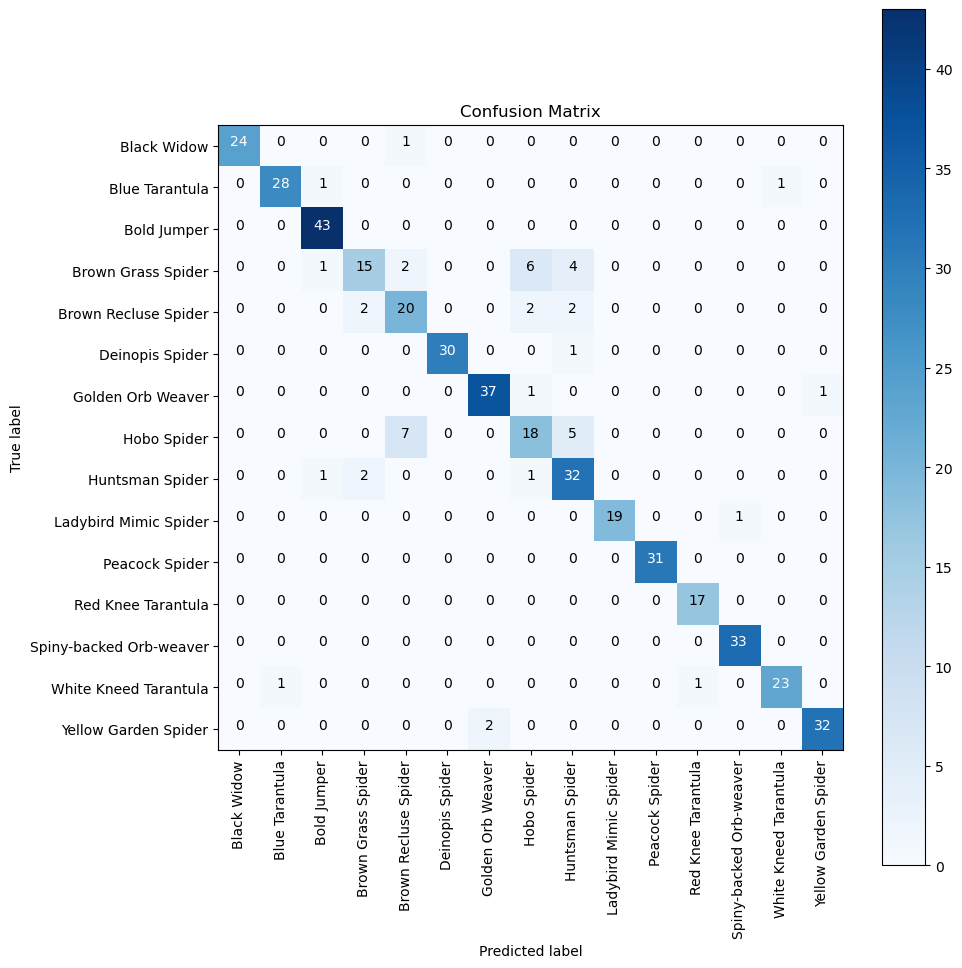

In [210]:
# Y_pred
Y_pred = model.predict_generator(test_generator)#, nb_test_samples // BATCH_SIZE, workers=1)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

# Classification Report
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

75/75 [==============================] - 4s 48ms/step


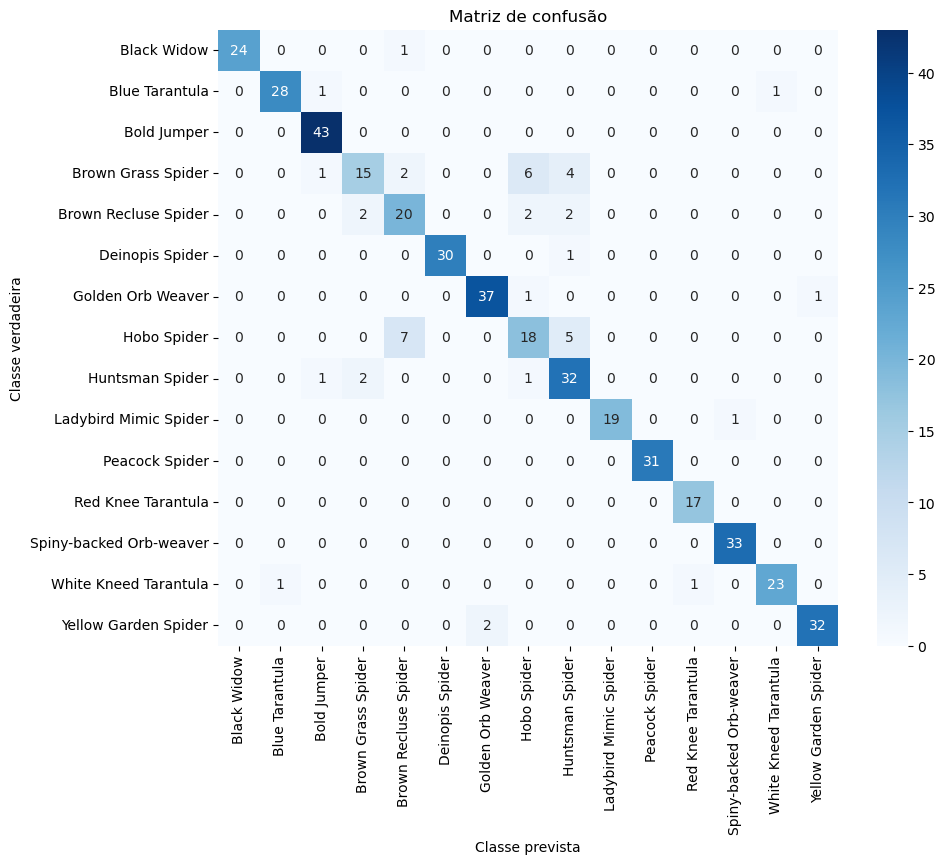

In [211]:
true_classes = test_generator.classes
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Classe prevista')
plt.ylabel('Classe verdadeira')
plt.title('Matriz de confusão')
plt.show()

# Resultados da grade de busca

In [213]:
'''
Resultados Convnext
'''
pd.DataFrame({
    'Otimizador'      :['Adam','Adam','Adam','Adam','SGD','SGD','SGD','SGD'],
    'Learning Rate'   :['0.001','0.0001','0.01','0.0001','0.001','0.0001','0.01','0.0001'],
    'Função Ativação' :['softmax','softmax','softmax','relu','softmax','softmax','softmax','relu'],
    'Acurácia'        :['0.8900','0.9000','0.8900','0.0600','0.8500','0.8300','0.8100','0.3000']
})

,Otimizador,Learning Rate,Função Ativação,Acurácia
0,Adam,0.001,softmax,0.8900
1,Adam,0.0001,softmax,0.9000
2,Adam,0.01,softmax,0.8900
3,Adam,0.0001,relu,0.0600
4,SGD,0.001,softmax,0.8500
5,SGD,0.0001,softmax,0.8300
6,SGD,0.01,softmax,0.8100
7,SGD,0.0001,relu,0.3000


# Análise Dos Experimentos

São apresentados em forma da tabela abaixo, a comparação dos modelos treinados em relação as métricas accuracy, precision e f1 score. 


In [215]:
pd.DataFrame({
    'Modelo'        :['0','1','2','3','4','5','6','7'], 
    'Acurácia'        :['0.8900','0.9000','0.8900','0.0600','0.8500','0.8300','0.8100','0.3000'], 
    'Média F1 Score'        :['0.8800','0.8900','0.8900','0.0100','0.8400','0.8100','0.8000','0.2800'],
    'Média Precision'        :['0.8900','0.9000','0.8900','0.0000','0.8500','0.8400','0.8100','0.3700']
})

,Modelo,Acurácia,Média F1 Score,Média Precision
0,0,0.8900,0.8800,0.8900
1,1,0.9000,0.8900,0.9000
2,2,0.8900,0.8900,0.8900
3,3,0.0600,0.0100,0.0000
4,4,0.8500,0.8400,0.8500
5,5,0.8300,0.8100,0.8400
6,6,0.8100,0.8000,0.8100
7,7,0.3000,0.2800,0.3700


Pode-se notar que os modelos que obtiveram os melhores resultados utilizaram a função de ativição softmax, percebe-se que ela tem um bom desempenho em tarefas de classificação. O Otimizador também foi um dos hiperparâmetros importantes para o treinamento dos modelos proposto e o que se destacou foi Adam para esse problema. 

Analisando as métricas dos modelos treinados conforme a tabela acima, o modelo 1 (Otimizador: Adam, Função de Ativação: sofwax e Learning rate: 0.0001) obteve uma acurácia de 90%, e uma precisão maior quando se compara com o modelo 2. Já fazendo uma comparação geral conseguiu o modelo 1 teve o  melhor desempenho.

Dessa forma, o algoritmo desenvolvido para este trabalho mostra-se eficiente para o problema de classificação de especies de aranhas como proposto inicialmente. Sendo assim, as métricas de acurácia, precisão, F1 Score e matriz de confusão, mostram que a redes desenvolvidas são aplicáveis a ambientes que aceitam essas métricas, cabendo a especialistas da área definir a aceitabilidade dos dados.